# recover trend using Bayesian structural time series model

## load libraries

In [1]:
# numerical libraries
import numpy as np
import scipy as sp
import pystan

# pandas!
import pandas as pd

# plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# clean up figures
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['grid.alpha'] = 0.25

## clean data

In [3]:
# load in data
covid_df = pd.read_csv('VDH-COVID-19-PublicUseDataset-Cases.csv')

# select counties
idx = covid_df['Locality'].isin(['Fairfax'])

# grab columns we need
ffx_df = covid_df[idx][['Report Date','Total Cases','Hospitalizations','Deaths']].copy()

# groupby date and sort
ffx_df = ffx_df.groupby(['Report Date']).sum().copy()
ffx_df.reset_index(inplace=True)
ffx_df['Report Date'] = pd.to_datetime(ffx_df['Report Date'])
ffx_df = ffx_df.sort_values(['Report Date'])

# columns to select
l_cols = ['Total Cases','Hospitalizations','Deaths']
d_cols = ['new_cases','new_hospitalizations','new_deaths']

# create first difference
ffx_delta_df = pd.DataFrame(np.array(ffx_df[1:][l_cols] - np.array(ffx_df[0:len(ffx_df)-1][l_cols])),
                            columns=d_cols)

# offset the date
ffx_delta_df['report_date'] = list(ffx_df['Report Date'][1:])

# add a day of week
dow_map = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
ffx_delta_df['day_of_week'] = [ffx_delta_df.loc[i,'report_date'].weekday() for i in ffx_delta_df.index]
ffx_delta_df['day_of_week'] = ffx_delta_df['day_of_week'].map(dow_map)

## plot data

/Users/daneel/miniconda3/envs/stan_dev/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


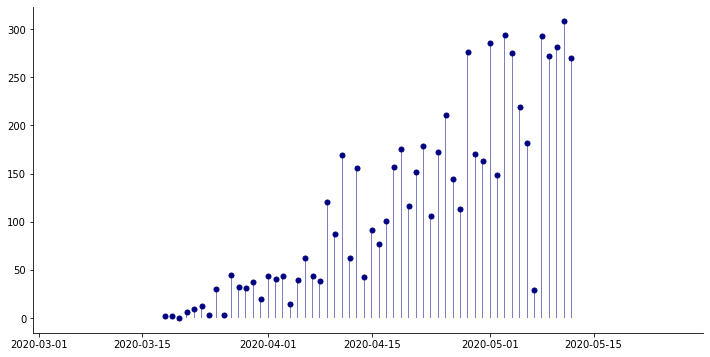

In [4]:
plt.figure(figsize=(12,6))
plt.scatter(ffx_delta_df['report_date'],ffx_delta_df['new_cases'],s=25,color='navy')
plt.bar(ffx_delta_df['report_date'],ffx_delta_df['new_cases'],align='center',width=0.15,alpha=0.5,color='navy');

## create indicator variable for 5/7/2020

In [5]:
# create indicator variable for 05/07/2020
ffx_delta_df['low_day'] = [1 if i == 50 else 0 for i in range(len(ffx_delta_df))]

In [6]:
ffx_delta_df[48:]

,new_cases,new_hospitalizations,new_deaths,report_date,day_of_week,low_day
48,219,16,3,2020-05-05,Tuesday,0
49,182,37,5,2020-05-06,Wednesday,0
50,29,8,5,2020-05-07,Thursday,1
51,293,49,16,2020-05-08,Friday,0
52,272,21,3,2020-05-09,Saturday,0
53,282,21,9,2020-05-10,Sunday,0
54,308,23,4,2020-05-11,Monday,0
55,270,26,10,2020-05-12,Tuesday,0


## recover trend

### compile Stan model

In [7]:
bsts = pystan.StanModel(file='lcl_lvl_irw.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e79150085e137362993ab4a5f42c1d6a NOW.


### feed model

In [8]:
# setup Stan dictionary
len_y = len(ffx_delta_df)

stan_data = {
    'T':len_y,
    'S':7,
    'INTR':51,
    'Y':np.log(1 + np.array(ffx_delta_df['new_cases']))
}

### estimate model

In [9]:
# conduct MCMC using Stan
fit = bsts.sampling(data=stan_data,
                    iter=800,
                    control={'max_treedepth':13,'adapt_delta':0.98},
                    chains=2
                   )
    
# extract samples
model_results = fit.extract(permuted=True)

In [10]:
print(fit.stansummary(pars=['s_v','s_w','s_Y','beta_intr']))

Inference for Stan model: anon_model_e79150085e137362993ab4a5f42c1d6a.
2 chains, each with iter=800; warmup=400; thin=1; 
post-warmup draws per chain=400, total post-warmup draws=800.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
s_v          0.1  1.8e-3   0.03   0.06   0.08    0.1   0.12   0.17    260    1.0
s_w         0.04  2.1e-3   0.04 1.6e-3   0.01   0.03   0.06   0.14    318    1.0
s_Y         0.52  2.0e-3   0.06   0.43   0.48   0.52   0.55   0.65    836    1.0
beta_intr  -2.08    0.02   0.63  -3.33   -2.5  -2.09  -1.64  -0.81    712    1.0

Samples were drawn using NUTS at Wed May 13 10:25:19 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


#### extract data from model

In [11]:
# extract local level trend
trend = np.mean(model_results['mu_exp'],axis=0) - 1
ffx_delta_df['trend'] = trend

# prediction
pred = np.mean(model_results['Y_sim_exp'],axis=0) - 1
ffx_delta_df['pred'] = pred

# day of week effects
dow = np.exp(np.mean(model_results['w'],axis=0)) - 1
ffx_delta_df['dow'] = dow

# slope of increase in new cases
slope = np.exp(np.mean(model_results['v'],axis=0)) - 1
ffx_delta_df['slope'] = slope

In [12]:
ffx_delta_df.tail(14)

,new_cases,new_hospitalizations,new_deaths,report_date,day_of_week,low_day,trend,pred,dow,slope
42,170,30,10,2020-04-29,Wednesday,0,191.545823,221.499190,-0.001427,0.038215
43,163,21,10,2020-04-30,Thursday,0,199.395635,217.428480,-0.037015,0.041199
44,286,37,3,2020-05-01,Friday,0,208.473884,247.322993,0.050997,0.044758
45,149,43,16,2020-05-02,Saturday,0,217.238045,252.887161,0.009720,0.041501
46,294,53,31,2020-05-03,Sunday,0,227.419410,267.336437,0.021282,0.045581
47,275,32,14,2020-05-04,Monday,0,234.919408,279.090683,0.009446,0.031938
48,219,16,3,2020-05-05,Tuesday,0,240.868115,265.432419,-0.048084,0.022949
49,182,37,5,2020-05-06,Wednesday,0,247.669675,281.194348,-0.007296,0.025984
50,29,8,5,2020-05-07,Thursday,1,255.642636,40.167631,-0.033200,0.031956
51,293,49,16,2020-05-08,Friday,0,264.713447,323.246624,0.050623,0.036769


In [13]:
# export data
ffx_delta_df.to_csv('ffx_covid_trend.csv')

#### plot trend

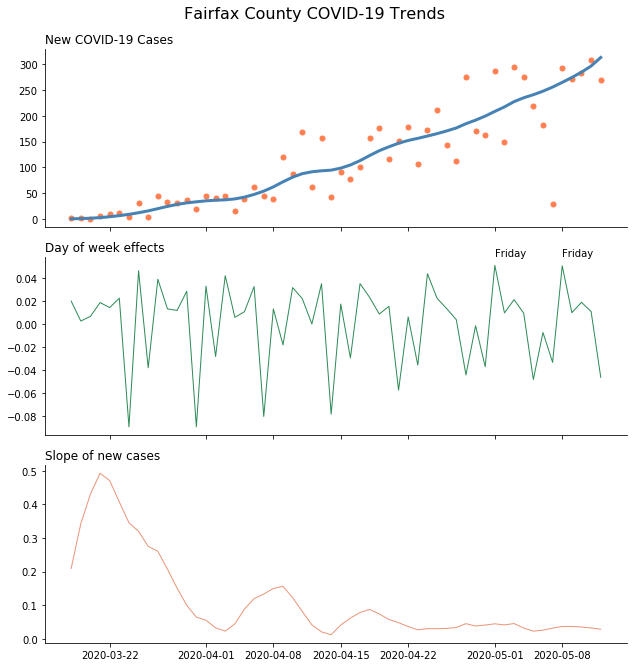

In [14]:
# setup figure
num_rows = 3
num_cols = 1
fig, ax = plt.subplots(num_rows, num_cols, figsize=(9, 9), sharex=True)

# set the title for the figure
st = fig.suptitle('Fairfax County COVID-19 Trends',y=1.025,fontsize=16)

# new cases trends
ax[0].plot(ffx_delta_df['report_date'],ffx_delta_df['new_cases'],'o',markersize=5,color='coral')
ax[0].plot(ffx_delta_df['report_date'],trend,lw=3,color='steelblue')
ax[0].set_title('New COVID-19 Cases',loc='left');

# day of week effects
ax[1].plot(ffx_delta_df['report_date'],dow,lw=1,color='seagreen')
ax[1].text(datetime.date(2020,5,1),0.059,'Friday')
ax[1].text(datetime.date(2020,5,8),0.059,'Friday')
ax[1].set_title('Day of week effects',loc='left')

# slope of new cases
ax[2].plot(ffx_delta_df['report_date'],slope,lw=1,color='darksalmon')
ax[2].set_title('Slope of new cases',loc='left')

fig.tight_layout();